# Problem 2

To refresh the memeory about arrays in python, please read

https://docs.scipy.org/doc/numpy-dev/user/quickstart.html

shape: (rows, columns)

## 1. Loading the dataset - Boston -

In [1]:
# load libraries
import numpy as np
import pandas as pd

In [2]:
dat = pd.read_csv('Boston.csv').dropna()
dat.head()

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,black,lstat,medv
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,396.90,5.33,36.2


In [157]:
# Extracting the data and the target.
X = np.array(dat.iloc[:,:-1].values)
#X = np.array(dat.iloc[:,[5,12]].values)
y = np.array(dat.iloc[:,13].values).reshape(-1,1)

In [158]:
print('X dim:', X.shape)
print('y dim:', y.shape)

X dim: (506, 13)
y dim: (506, 1)


In [159]:
#np.asscalar(np.dot(X.T,y))

In [160]:
from sklearn.model_selection import train_test_split

In [161]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.5, random_state=0)

In [162]:
from sklearn.preprocessing import StandardScaler
sc_x = StandardScaler()
sc_y = StandardScaler()

In [163]:
X_train_sc=sc_x.fit_transform(X_train)
y_train_sc=sc_y.fit_transform(y_train.reshape(-1,1))

X_test_sc = sc_x.transform(X_test)
y_test_sc = sc_y.transform(y_test.reshape(-1,1))

### 1.1. Exploratory Data Analysis

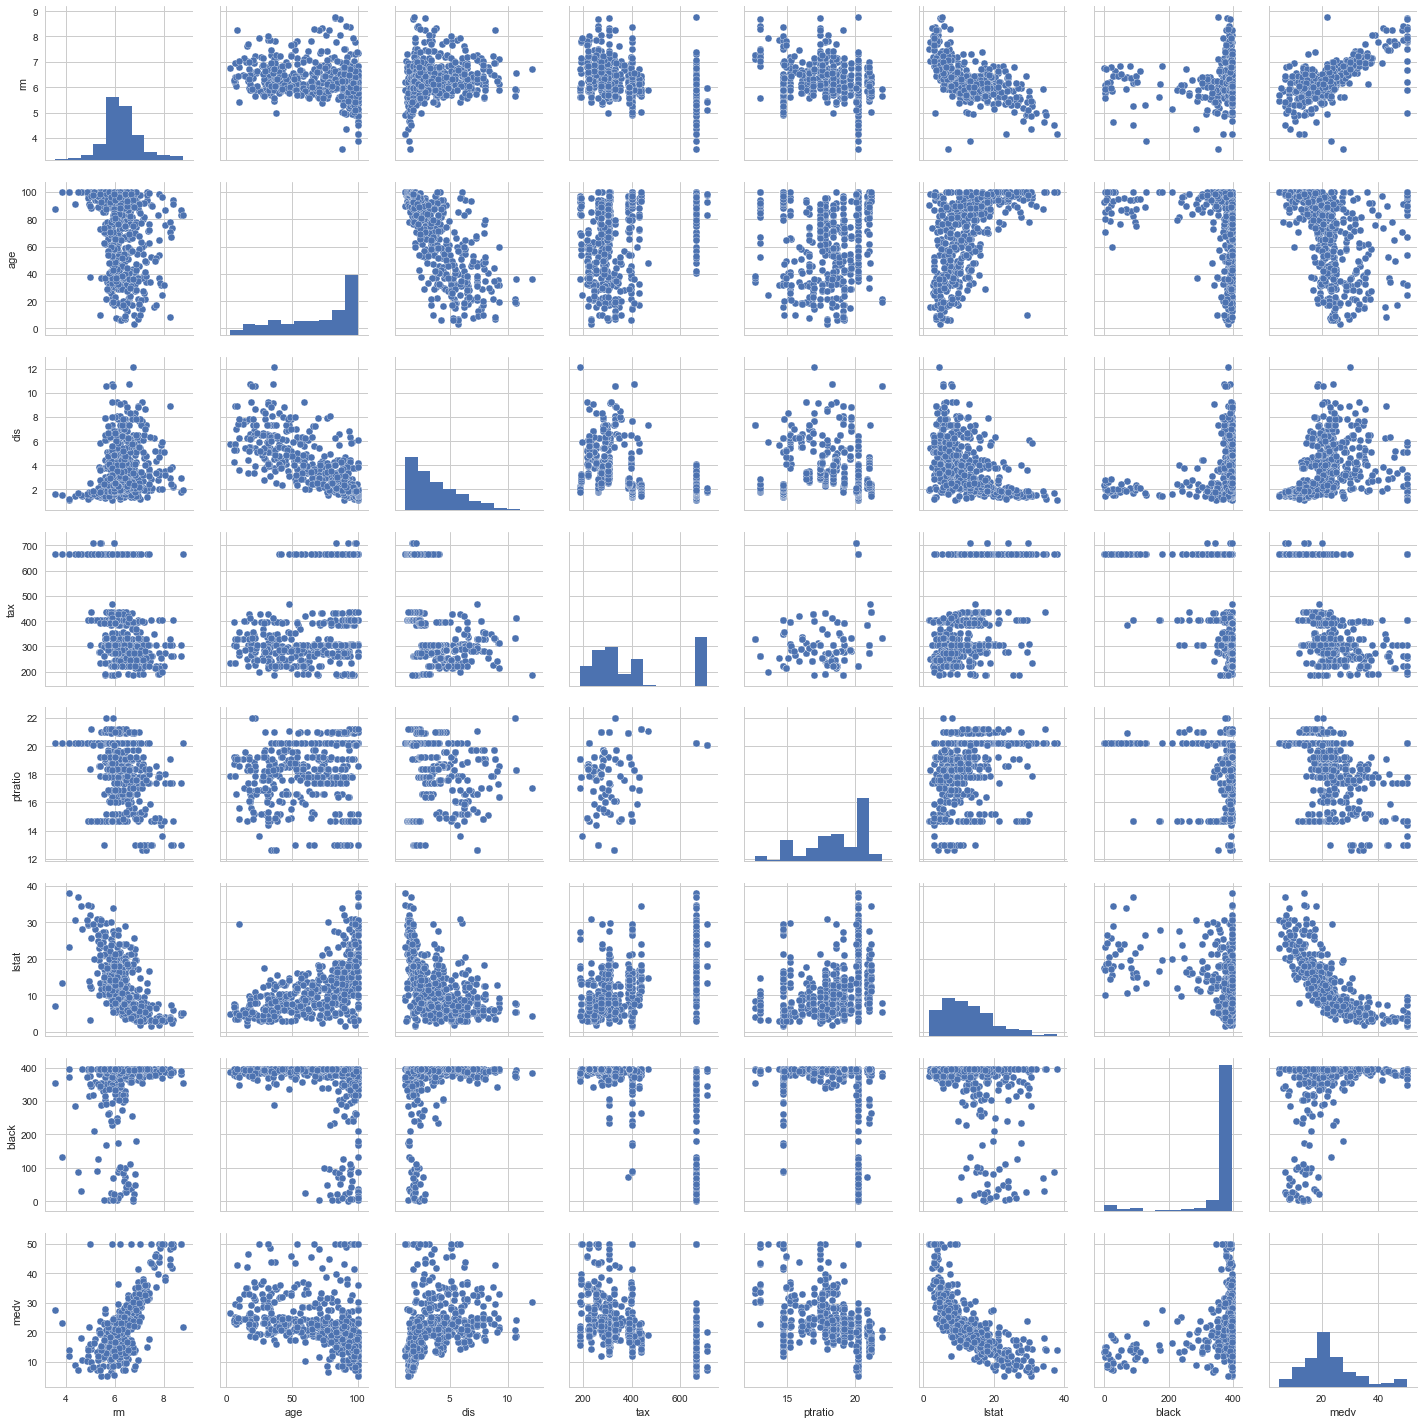

In [164]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style='whitegrid', context='notebook')
cols = [ 'rm', 'age', 'dis', 'tax','ptratio','lstat','black','medv']
sns.pairplot(dat[cols], size=2.5)
plt.show()

### 1.2. Constructing the weight matrix

In [165]:
from sklearn.linear_model import LinearRegression
slr=LinearRegression()
slr.fit(X_train_sc, y_train_sc)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [166]:
res = slr.predict(X_train_sc) - y_train_sc

In [167]:
# creating the weight matrix and normalizing it
W = np.diagflat(1/res**2)
Wmax=np.amax(W)

In [168]:
W = W/ Wmax

In [169]:
# I want to use the identity for now.. 
W =np.identity(X_train_sc.shape[0])

In [170]:
slr.coef_

array([[-0.1160751 ,  0.1438898 ,  0.05387264,  0.08823602, -0.19912322,
         0.27192659, -0.00881289, -0.32867001,  0.22535303, -0.17490753,
        -0.2542458 ,  0.05282481, -0.4393473 ]])

In [171]:
slr.intercept_

array([  3.03766202e-15])

## 2. The optimization algorithms

### 2.1. Sub-gradient Descent

In [227]:
# Introducing the sub-gradient descent algorithm
import numpy as np
import time

class WEN_sGD(object):
    
    def __init__(self, lambda_1, lambda_2, eta=0.01, n_iter=50, feedback=False):
        self.lambda_1 = lambda_1
        self.lambda_2 = lambda_2
        self.eta      = eta 
        self.n_iter   = n_iter
        self.feedback = feedback
        
    def fit(self, X, y, W):
        self.beta_ = np.zeros(1+X.shape[1]).reshape(-1,1)
        self.cost_ = []
        
        time0 = time.clock()
        
        # Defining the X0 vector
        X0 = np.ones(X.shape[0]).reshape(-1,1)

        #print('X0:', X0)
            
        # Defining a few useful terms
        ID     = np.identity(X.shape[1])
        Xt     = np.transpose(X)
        yt     = np.transpose(y)
        
        WX     = W    @ X
        XtW    = X.T  @ W
        XtWX   = XtW  @ X
        WX0    = W    @ X0
        X0tW   = X0.T @ W
        XtWX0  = XtW  @ X0
        X0tWX  = X0tW @ X
        X0tWX0 = np.asscalar(X0.T @ WX0)
        ytWX0  = np.asscalar(y.T  @ WX0)
        ytW    = y.T  @ W
        
        if(self.feedback):
            print('Time to compute the linalg elements:', time.clock() - time0) 
            print('')
            print('--- Optimization: ---')
        
        time1 = time.clock()
        
        for i_iter in range(self.n_iter):
            
            # Defining quantities depending on beta
            b     = self.beta_[1:]
            b0    = self.beta_[0]
            bt    = b.T            
            Xb    = X   @ b
            WXb   = W   @ Xb
            ytWXb = np.asscalar(y.T @ WXb)
            
            obj = (np.asscalar(bt @ (XtWX @ b)) + self.lambda_2*np.asscalar(bt @ b) + 2*b0 * np.asscalar(bt @ XtWX0)
                   + b0**2 * (X0tWX0 + self.lambda_2))
            
            obj = obj/(1.+self.lambda_2)
            
            obj = obj - 2*ytWXb - 2*b0*ytWX0
            
            # computing the lasso penalization
            lasso = 0
            # Apparently we do not regularize the intercept.
            for i in range(1,1+X.shape[1]):
                lasso += abs(self.beta_[i])
                
            lasso = lasso*self.lambda_1
            
            # adding the rest
            obj += lasso
            
            # store the cost function
            if (self.feedback):
                print('iter:', i_iter, 'obj:', obj)
                
            self.cost_.append(obj)
            
            # Now update the regressioin coefficients
            # L =/ 0
            for L in range(X.shape[1]):

                # doing some operations
                XL     = X[:,L].reshape(-1,1)
                XLt    = XL.T
                XLtWXb = np.asscalar(XL.T @ WXb)
                XLtWX0 = np.asscalar(XL.T @ WX0)
                ytWXL  = np.asscalar(ytW @ XL)
                
                # useful outputs
                #print('XL     shape:', XL.shape)
                #print('XLt    shape:', XLt.shape)
                #print('XLtWXb shape:', XLtWXb.shape)
                #print('ytWX0  shape:', ytWX0.shape)
                #print('ytWXL  shape:', ytWXL.shape)
                
                grad = 2*((XLtWXb+self.lambda_2*self.beta_[L+1] + XLtWX0)/(1+self.lambda_2)- ytWXL)
                
                # subgradient part
                if (self.beta_[1+L] >  0):
                    grad = grad+self.lambda_1
                elif(self.beta_[1+L] < 0):
                    grad = grad - self.lambda_1
                
                self.beta_[1+L] += self.eta*(-grad)
                
            # Updating the intercept
            grad0 = 2*((np.asscalar(X0tWX @ b) + X0tWX0 *b0+self.lambda_2*b0)/(1+self.lambda_2)- ytWX0)
            
            if (self.beta_[0]>0):
                grad0+=self.lambda_1
            elif(self.beta_[0]<0):
                grad0+=(-self.lambda_1)
            
            self.beta_[0]+=grad0*(-self.eta)
            
        if(self.feedback): 
            print('Time for optimization:', time.clock()-time1)
        
        return self

    def predict(self, X):
        Xbeta = np.dot(X, self.beta_[1:])+self.beta_[0]
        return Xbeta     
            

### 2.2. Proximal Gradient Descent

We can easily modify the sub-gradient descent to obtain the proximal gradient descent.

In [228]:
import numpy as np
import time

class WEN_pGD(object):
    
    def __init__(self, lambda_1, lambda_2, eta=0.01, n_iter=50, feedback=False):
        self.lambda_1 = lambda_1
        self.lambda_2 = lambda_2
        self.eta      = eta 
        self.n_iter   = n_iter
        self.feedback = feedback
        
    def fit(self, X, y, W):
        self.beta_ = np.zeros(1+X.shape[1]).reshape(-1,1)
        self.cost_ = []
        
        time0 = time.clock()
        
        # Defining the X0 vector
        X0 = np.ones(X.shape[0]).reshape(-1,1)
            
        # Defining a few useful terms
        ID     = np.identity(X.shape[1])
        Xt     = np.transpose(X)
        yt     = np.transpose(y)
        
        WX     = W    @ X
        XtW    = X.T  @ W
        XtWX   = XtW  @ X
        WX0    = W    @ X0
        X0tW   = X0.T @ W
        XtWX0  = XtW  @ X0
        X0tWX  = X0tW @ X
        X0tWX0 = np.asscalar(X0.T @ WX0)
        ytWX0  = np.asscalar(y.T  @ WX0)
        ytW    = y.T  @ W
        
        if(self.feedback):
            print('Time to compute the linalg elements:', time.clock() - time0)
            print('')
            print('--- Optimization: ---')
            
        time1 = time.clock()
        
        for i_iter in range(self.n_iter):
            
            # Defining quantities depending on beta
            b     = self.beta_[1:]
            b0    = self.beta_[0]
            bt    = b.T            
            Xb    = X   @ b
            WXb   = W   @ Xb
            ytWXb = np.asscalar(y.T @ WXb)
            
            obj = (np.asscalar(bt @ (XtWX @ b)) + self.lambda_2*np.asscalar(bt @ b) + 2*b0 * np.asscalar(bt @ XtWX0)
                   + b0**2 * (X0tWX0 + self.lambda_2))
            
            obj = obj/(1.+self.lambda_2)
            
            obj = obj - 2*ytWXb - 2*b0*ytWX0
            
            # computing the lasso penalization
            lasso = 0
            
            # Apparently we do not regularize the intercept.
            for i in range(1,1+X.shape[1]):
                lasso += abs(self.beta_[i])
                
            lasso = lasso*self.lambda_1
            
            # adding the rest
            obj += lasso
            
            # store the cost function
            self.cost_.append(obj)
            
            # print the cost function
            if(self.feedback):
                print('iter:', i_iter, 'obj:', obj)
            
            # Now update the regressioin coefficients using the proximal GD
            # L =/ 0
            
            for L in range(X.shape[1]):

                # doing some operations
                XL     = X[:,L].reshape(-1,1)
                XLt    = XL.T
                XLtWXb = np.asscalar(XL.T @ WXb)
                XLtWX0 = np.asscalar(XL.T @ WX0)
                ytWXL  = np.asscalar(ytW @ XL)
                
                grad = 2*((XLtWXb+self.lambda_2*self.beta_[L+1] + XLtWX0)/(1+self.lambda_2)- ytWXL)
                
                # arguments of the soft threshold function
                x   = self.beta_[1+L] - self.eta * grad
                lam = self.eta*self.lambda_1
                
                self.beta_[1+L] = self.soft_threshold(x, lam)
                
            # Updating the intercept
            grad0 = 2*((np.asscalar(X0tWX @ b) + X0tWX0 *b0+self.lambda_2*b0)/(1+self.lambda_2)- ytWX0)
            
            x   = self.beta_[0] - self.eta*grad0
            lam = self.eta*self.lambda_1
            
            self.beta_[0] = self.soft_threshold(x,lam)
            
            
        #print('Time for optimization:', time.clock()-time1)
        
        return self

    def predict(self, X):
        Xbeta = np.dot(X, self.beta_[1:])+self.beta_[0]
        return Xbeta     
            
    def soft_threshold(self, x, lam):
        if (x > lam):
            st = x-lam
        elif(x < -lam):
            st = x+lam
        else:
            st = 0
        
        return st

## 3. Testing the algorithms

### 3.1. OLS limit of the two algorithms
Below I try the two algorithms above using $\lambda_1 = \lambda_2 = 0$. This is exaclty the same as the OLS and the two algorithms should be the same in this case.

In [229]:
wen1 = WEN_sGD(lambda_1=0,lambda_2=0,eta=0.0001,n_iter=200,feedback=True)
wen2 = WEN_pGD(lambda_1=0,lambda_2=0,eta=0.0001,n_iter=200,feedback=True)

In [230]:
wen1.fit(X_train_sc, y_train_sc, W)

Time to compute the linalg elements: 0.005971000000002391

--- Optimization: ---
iter: 0 obj: [ 0.]
iter: 1 obj: [-61.40707553]
iter: 2 obj: [-95.73776463]
iter: 3 obj: [-116.39384617]
iter: 4 obj: [-129.93755994]
iter: 5 obj: [-139.60872421]
iter: 6 obj: [-147.02987237]
iter: 7 obj: [-153.0333465]
iter: 8 obj: [-158.06285809]
iter: 9 obj: [-162.3687726]
iter: 10 obj: [-166.10336101]
iter: 11 obj: [-169.36750496]
iter: 12 obj: [-172.23381085]
iter: 13 obj: [-174.75823278]
iter: 14 obj: [-176.98607442]
iter: 15 obj: [-178.95522076]
iter: 16 obj: [-180.69798683]
iter: 17 obj: [-182.24226075]
iter: 18 obj: [-183.61227363]
iter: 19 obj: [-184.82916159]
iter: 20 obj: [-185.91140316]
iter: 21 obj: [-186.8751757]
iter: 22 obj: [-187.73465423]
iter: 23 obj: [-188.50226675]
iter: 24 obj: [-189.18891444]
iter: 25 obj: [-189.80416282]
iter: 26 obj: [-190.3564083]
iter: 27 obj: [-190.85302343]
iter: 28 obj: [-191.30048394]
iter: 29 obj: [-191.7044797]
iter: 30 obj: [-192.07001185]
iter: 31 obj: [-

In [231]:
wen2.fit(X_train_sc, y_train_sc, W)

Time to compute the linalg elements: 0.0027819999999962874

--- Optimization: ---
iter: 0 obj: [ 0.]
iter: 1 obj: [-61.40707553]
iter: 2 obj: [-95.73776463]
iter: 3 obj: [-116.39384617]
iter: 4 obj: [-129.93755994]
iter: 5 obj: [-139.60872421]
iter: 6 obj: [-147.02987237]
iter: 7 obj: [-153.0333465]
iter: 8 obj: [-158.06285809]
iter: 9 obj: [-162.3687726]
iter: 10 obj: [-166.10336101]
iter: 11 obj: [-169.36750496]
iter: 12 obj: [-172.23381085]
iter: 13 obj: [-174.75823278]
iter: 14 obj: [-176.98607442]
iter: 15 obj: [-178.95522076]
iter: 16 obj: [-180.69798683]
iter: 17 obj: [-182.24226075]
iter: 18 obj: [-183.61227363]
iter: 19 obj: [-184.82916159]
iter: 20 obj: [-185.91140316]
iter: 21 obj: [-186.8751757]
iter: 22 obj: [-187.73465423]
iter: 23 obj: [-188.50226675]
iter: 24 obj: [-189.18891444]
iter: 25 obj: [-189.80416282]
iter: 26 obj: [-190.3564083]
iter: 27 obj: [-190.85302343]
iter: 28 obj: [-191.30048394]
iter: 29 obj: [-191.7044797]
iter: 30 obj: [-192.07001185]
iter: 31 obj: [

In [232]:
print('beta1:',wen1.beta_)
print('beta2:',wen2.beta_)

beta1: [[  2.97180600e-15]
 [ -1.10445498e-01]
 [  1.20662849e-01]
 [  2.12788821e-03]
 [  9.69195524e-02]
 [ -1.40674761e-01]
 [  2.99595671e-01]
 [ -2.40304100e-02]
 [ -2.91557346e-01]
 [  1.24675751e-01]
 [ -6.75159337e-02]
 [ -2.42036442e-01]
 [  5.52335834e-02]
 [ -4.22336141e-01]]
beta2: [[  2.97180600e-15]
 [ -1.10445498e-01]
 [  1.20662849e-01]
 [  2.12788821e-03]
 [  9.69195524e-02]
 [ -1.40674761e-01]
 [  2.99595671e-01]
 [ -2.40304100e-02]
 [ -2.91557346e-01]
 [  1.24675751e-01]
 [ -6.75159337e-02]
 [ -2.42036442e-01]
 [  5.52335834e-02]
 [ -4.22336141e-01]]


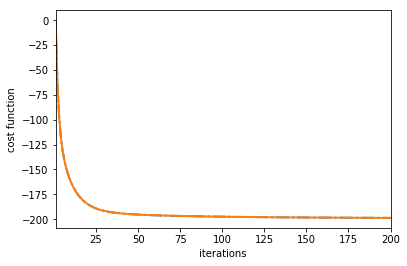

In [233]:
sns.reset_orig()
plt.plot(range(1, wen1.n_iter+1), wen1.cost_, linewidth =2, linestyle= '-.')
plt.plot(range(1, wen2.n_iter+1), wen2.cost_, linewidth =2, linestyle = '-')
plt.xlim(1,200)
plt.ylabel('cost function')
plt.xlabel('iterations')
plt.show()

### 3.2. Lasso Limit

Here we set only $\lambda_2 = 0$ and compare the result with the Lasso model from sklearn

#### 3.1. Choosing the best $\lambda_1$

In [234]:
from sklearn.linear_model import Lasso
from sklearn.metrics import r2_score

param_range = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]
for i in range(len(param_range)):
    lasso = Lasso(alpha=param_range[i], random_state=1)
    lasso.fit(X_train_sc,y_train_sc)
    r2=r2_score(y_test_sc, lasso.predict(X_test_sc))
    print('lambda:', lasso.alpha, 'r2:', r2)
    

lambda: 0.0001 r2: 0.666291334493
lambda: 0.001 r2: 0.666377542875
lambda: 0.01 r2: 0.659947175286
lambda: 0.1 r2: 0.622993714681
lambda: 1 r2: -0.0140588213417
lambda: 10 r2: -0.0140588213417
lambda: 100 r2: -0.0140588213417
lambda: 1000 r2: -0.0140588213417


In [240]:
lasso = Lasso(alpha=0.1, random_state = 1)
lasso.fit(X_train_sc, y_train_sc)
print('intercept:', lasso.intercept_)
print('coeff    :', lasso.coef_)

intercept: [  2.30760042e-15]
coeff    : [-0.          0.         -0.          0.02467933 -0.          0.29352588
 -0.         -0.         -0.         -0.         -0.19596504  0.
 -0.40008272]


In [241]:
# now trying the wen in this limit.
wen1 = WEN_sGD(lambda_1=0.1,lambda_2=0,eta=0.0001,n_iter=200,feedback=True)
wen2 = WEN_pGD(lambda_1=0.1,lambda_2=0,eta=0.0001,n_iter=200,feedback=True)

In [242]:
wen1.fit(X_train_sc, y_train_sc, W)

Time to compute the linalg elements: 0.0034229999999979555

--- Optimization: ---
iter: 0 obj: [ 0.]
iter: 1 obj: [-61.37881383]
iter: 2 obj: [-95.67465021]
iter: 3 obj: [-116.31217682]
iter: 4 obj: [-129.84545475]
iter: 5 obj: [-139.51031084]
iter: 6 obj: [-146.92731928]
iter: 7 obj: [-152.92664941]
iter: 8 obj: [-157.95106115]
iter: 9 obj: [-162.25235147]
iter: 10 obj: [-165.98278327]
iter: 11 obj: [-169.24320453]
iter: 12 obj: [-172.10617923]
iter: 13 obj: [-174.6276184]
iter: 14 obj: [-176.85278502]
iter: 15 obj: [-178.81952728]
iter: 16 obj: [-180.56012732]
iter: 17 obj: [-182.10244434]
iter: 18 obj: [-183.47068402]
iter: 19 obj: [-184.68596026]
iter: 20 obj: [-185.76673216]
iter: 21 obj: [-186.72908733]
iter: 22 obj: [-187.58638297]
iter: 23 obj: [-188.351974]
iter: 24 obj: [-189.03674535]
iter: 25 obj: [-189.6502478]
iter: 26 obj: [-190.20086436]
iter: 27 obj: [-190.6959557]
iter: 28 obj: [-191.14198689]
iter: 29 obj: [-191.54463839]
iter: 30 obj: [-191.90890293]
iter: 31 obj: [

In [211]:
wen2.fit(X_train_sc, y_train_sc, W)

iter: 0 obj: [ 0.]
iter: 1 obj: [-61.35858254]
iter: 2 obj: [-95.66398424]
iter: 3 obj: [-116.3062605]
iter: 4 obj: [-129.84193998]
iter: 5 obj: [-139.50804683]
iter: 6 obj: [-146.92573718]
iter: 7 obj: [-152.92404351]
iter: 8 obj: [-157.94869123]
iter: 9 obj: [-162.25021838]
iter: 10 obj: [-165.98087204]
iter: 11 obj: [-169.2414944]
iter: 12 obj: [-172.10464851]
iter: 13 obj: [-174.62624632]
iter: 14 obj: [-176.8515527]
iter: 15 obj: [-178.81841777]
iter: 16 obj: [-180.55912571]
iter: 17 obj: [-182.10153749]
iter: 18 obj: [-183.46986045]
iter: 19 obj: [-184.68520994]
iter: 20 obj: [-185.76604632]
iter: 21 obj: [-186.72797756]
iter: 22 obj: [-187.58535582]
iter: 23 obj: [-188.35102125]
iter: 24 obj: [-189.03585946]
iter: 25 obj: [-189.64942191]
iter: 26 obj: [-190.20009236]
iter: 27 obj: [-190.69523212]
iter: 28 obj: [-191.14130689]
iter: 29 obj: [-191.54399764]
iter: 30 obj: [-191.90829761]
iter: 31 obj: [-192.23859716]
iter: 32 obj: [-192.53875804]
iter: 33 obj: [-192.8121784]
iter: 

In [212]:
print('beta1:',wen1.beta_)
print('beta2:',wen2.beta_)

beta1: [[ -5.12995044e-06]
 [ -1.10001706e-01]
 [  1.20257077e-01]
 [  1.99922126e-03]
 [  9.68177225e-02]
 [ -1.40054505e-01]
 [  2.99702690e-01]
 [ -2.36129843e-02]
 [ -2.90425953e-01]
 [  1.23289825e-01]
 [ -6.65926085e-02]
 [ -2.41872004e-01]
 [  5.50311570e-02]
 [ -4.22432733e-01]]
beta2: [[ 0.        ]
 [-0.11000059]
 [ 0.12025471]
 [ 0.00198382]
 [ 0.09681845]
 [-0.14005032]
 [ 0.29970214]
 [-0.02361092]
 [-0.29042604]
 [ 0.12328669]
 [-0.06658552]
 [-0.2418706 ]
 [ 0.05503049]
 [-0.42243155]]


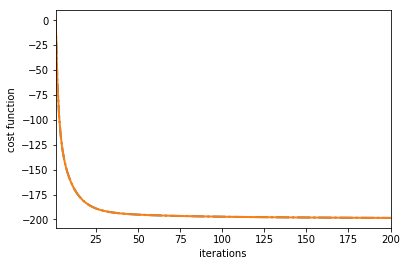

In [215]:
sns.reset_orig()
plt.plot(range(1, wen1.n_iter+1), wen1.cost_, linewidth =2, linestyle= '-.')
plt.plot(range(1, wen2.n_iter+1), wen2.cost_, linewidth =2, linestyle = '-')
plt.xlim(1,200)
plt.ylabel('cost function')
plt.xlabel('iterations')
plt.show()

### 3.3. Elastic Net

In [216]:
from sklearn.linear_model import ElasticNet
EN = ElasticNet(alpha=0.1, l1_ratio = 0.5)

In [217]:
EN.fit(X_train_sc,y_train_sc)

ElasticNet(alpha=0.1, copy_X=True, fit_intercept=True, l1_ratio=0.5,
      max_iter=1000, normalize=False, positive=False, precompute=False,
      random_state=None, selection='cyclic', tol=0.0001, warm_start=False)

In [218]:
EN.coef_

array([-0.04194283,  0.01396064, -0.        ,  0.06394407, -0.        ,
        0.31307306, -0.        , -0.03597465, -0.        , -0.        ,
       -0.21365497,  0.02159764, -0.39610077])

In [219]:
EN.intercept_

array([  2.54303424e-15])

In [220]:
wen1 = WEN_sGD(lambda_1=0.01,lambda_2=0.02,eta=0.0001,n_iter=200)
wen2 = WEN_pGD(lambda_1=0.2,lambda_2=0.1,eta=0.0001,n_iter=200)

In [221]:
wen1.fit(X_train_sc, y_train_sc, W)

iter: 0 obj: [ 0.]
iter: 1 obj: [-61.58641952]
iter: 2 obj: [-96.44748429]
iter: 3 obj: [-117.60195572]
iter: 4 obj: [-131.52939805]
iter: 5 obj: [-141.48056492]
iter: 6 obj: [-149.10790185]
iter: 7 obj: [-155.26987194]
iter: 8 obj: [-160.42829237]
iter: 9 obj: [-164.84499792]
iter: 10 obj: [-168.67880127]
iter: 11 obj: [-172.03416456]
iter: 12 obj: [-174.98556214]
iter: 13 obj: [-177.58988176]
iter: 14 obj: [-179.89288199]
iter: 15 obj: [-181.93267756]
iter: 16 obj: [-183.74172245]
iter: 17 obj: [-185.34801983]
iter: 18 obj: [-186.77592221]
iter: 19 obj: [-188.04670449]
iter: 20 obj: [-189.17900294]
iter: 21 obj: [-190.18916888]
iter: 22 obj: [-191.09152867]
iter: 23 obj: [-191.89867981]
iter: 24 obj: [-192.6217853]
iter: 25 obj: [-193.27060711]
iter: 26 obj: [-193.85373522]
iter: 27 obj: [-194.37873075]
iter: 28 obj: [-194.85225132]
iter: 29 obj: [-195.28016086]
iter: 30 obj: [-195.66762593]
iter: 31 obj: [-196.01920023]
iter: 32 obj: [-196.3388987]
iter: 33 obj: [-196.63026261]
iter

In [222]:
wen2.fit(X_train_sc, y_train_sc, W)

iter: 0 obj: [ 0.]
iter: 1 obj: [-62.15326275]
iter: 2 obj: [-98.95980251]
iter: 3 obj: [-122.0206258]
iter: 4 obj: [-137.46464466]
iter: 5 obj: [-148.54890667]
iter: 6 obj: [-157.021046]
iter: 7 obj: [-163.82988944]
iter: 8 obj: [-169.50845734]
iter: 9 obj: [-174.3665026]
iter: 10 obj: [-178.59112009]
iter: 11 obj: [-182.30314094]
iter: 12 obj: [-185.58609515]
iter: 13 obj: [-188.50167732]
iter: 14 obj: [-191.09810958]
iter: 15 obj: [-193.41475448]
iter: 16 obj: [-195.48473707]
iter: 17 obj: [-197.33650073]
iter: 18 obj: [-198.99478356]
iter: 19 obj: [-200.48127271]
iter: 20 obj: [-201.81507372]
iter: 21 obj: [-203.01306832]
iter: 22 obj: [-204.09020111]
iter: 23 obj: [-205.05872271]
iter: 24 obj: [-205.9305298]
iter: 25 obj: [-206.7170083]
iter: 26 obj: [-207.4274075]
iter: 27 obj: [-208.0699412]
iter: 28 obj: [-208.65190608]
iter: 29 obj: [-209.17978603]
iter: 30 obj: [-209.65934431]
iter: 31 obj: [-210.0957051]
iter: 32 obj: [-210.49342563]
iter: 33 obj: [-210.85656008]
iter: 34 ob

In [223]:
print('beta1:',wen1.beta_)
print('beta2:',wen2.beta_)

beta1: [[ -5.12738951e-07]
 [ -1.12519499e-01]
 [  1.22445235e-01]
 [  1.54365569e-03]
 [  9.89981645e-02]
 [ -1.41860108e-01]
 [  3.06448064e-01]
 [ -2.47162383e-02]
 [ -2.95832950e-01]
 [  1.25615181e-01]
 [ -6.75581935e-02]
 [ -2.46577666e-01]
 [  5.64413370e-02]
 [ -4.30169484e-01]]
beta2: [[ 0.        ]
 [-0.12008769]
 [ 0.12881069]
 [-0.00054779]
 [ 0.10715703]
 [-0.14529789]
 [ 0.33431213]
 [-0.02678873]
 [-0.31057054]
 [ 0.12698263]
 [-0.06632407]
 [-0.26443404]
 [ 0.06099137]
 [-0.46145082]]


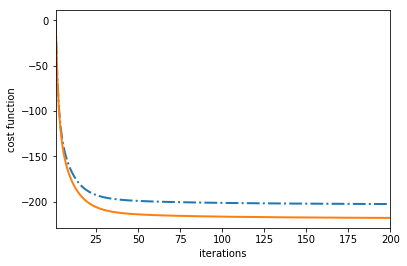

In [225]:
sns.reset_orig()
plt.plot(range(1, wen1.n_iter+1), wen1.cost_, linewidth =2, linestyle= '-.')
plt.plot(range(1, wen2.n_iter+1), wen2.cost_, linewidth =2, linestyle = '-')
plt.xlim(1,200)
plt.ylabel('cost function')
plt.xlabel('iterations')
plt.show()

In [244]:
# Choosing the regularization parameters
from sklearn.metrics import r2_score

param_range = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]
print('--- SUB-GRADIENT ---')
print('lam1, lam2, r2')
for i in range(len(param_range)):
    for j in range(len(param_range)):
        lambda_1 = param_range[i]
        lambda_2 = param_range[j]
        wen1 = WEN_sGD(lambda_1=lambda_1,lambda_2=lambda_2,eta=0.0001,n_iter=200)
        wen1.fit(X_train_sc, y_train_sc,W)
        nz = np.count_nonzero(wen1.beta_)
        r2=r2_score(y_test_sc,wen1.predict(X_test_sc))
        print(lambda_1, lambda_2, r2, nz)
print('')
print('--- PROXIMAL GRADIENT ---')
print('lam1, lam2, r2')
for i in range(len(param_range)):
    for j in range(len(param_range)):
        lambda_1 = param_range[i]
        lambda_2 = param_range[j]
        wen2 = WEN_pGD(lambda_1=lambda_1,lambda_2=lambda_2,eta=0.0001,n_iter=200)
        wen2.fit(X_train_sc, y_train_sc,W)
        nz = np.count_nonzero(wen2.beta_)
        r2=r2_score(y_test_sc,wen2.predict(X_test_sc))
        print(lambda_1, lambda_2, r2,nz)
        


--- SUB-GRADIENT ---
lam1, lam2, r2
0.0001 0.0001 0.661391743475 14
0.0001 0.001 0.66123428952 14
0.0001 0.01 0.659583729342 14
0.0001 0.1 0.635475515866 14
0.0001 1 -0.361342753114 14
0.0001 10 -62.7305612848 14
0.0001 100 -965.943428749 14
0.0001 1000 -1594.98070047 14
0.001 0.0001 0.661391301827 14
0.001 0.001 0.661233851282 14
0.001 0.01 0.659583317534 14
0.001 0.1 0.63547542407 14
0.001 1 -0.361333348989 14
0.001 10 -62.7300851684 14
0.001 100 -965.935519309 14
0.001 1000 -1594.96772137 14
0.01 0.0001 0.661386997913 14
0.01 0.001 0.661229461071 14
0.01 0.01 0.659579191563 14
0.01 0.1 0.635474497291 14
0.01 1 -0.361239324583 14
0.01 10 -62.7253241318 14
0.01 100 -965.85642674 14
0.01 1000 -1594.83793334 14
0.1 0.0001 0.661343055737 14
0.1 0.001 0.661185981705 14
0.1 0.01 0.659537142505 14
0.1 0.1 0.63546434774 14
0.1 1 -0.360300765688 14
0.1 10 -62.6777265442 14
0.1 100 -965.065684318 14
0.1 1000 -1593.54034905 14
1 0.0001 0.660890066063 14
1 0.001 0.660723842587 14
1 0.01 0.659103

In [248]:
wen1 = WEN_sGD(lambda_1=10,lambda_2=0.0001,eta=0.0001,n_iter=200)
t0 = time.clock()
wen1.fit(X_train_sc, y_train_sc, W)
t1 = time.clock()
wen2 = WEN_pGD(lambda_1=10,lambda_2=0.0001,eta=0.0001,n_iter=200)
t2 = time.clock()
wen2.fit(X_train_sc,y_train_sc,W)
t3 = time.clock()

In [249]:
print('Sub-Gradient  time:', t1-t0)
print('Prox-Gradient time:', t3-t2)

Sub-Gradient  time: 0.2020869999999917
Prox-Gradient time: 0.15169199999999705


In [250]:
print('beta_1:',wen1.beta_)
print('beta_2:',wen2.beta_)

beta_1: [[ -5.12993735e-04]
 [ -6.68617814e-02]
 [  7.98692528e-02]
 [  2.75483953e-04]
 [  8.64993701e-02]
 [ -6.91105832e-02]
 [  3.11271200e-01]
 [ -7.75680659e-04]
 [ -1.85395826e-01]
 [  6.83843184e-05]
 [ -1.40775340e-03]
 [ -2.22422478e-01]
 [  3.48662655e-02]
 [ -4.27610340e-01]]
beta_2: [[ 0.        ]
 [-0.06674397]
 [ 0.07988163]
 [ 0.        ]
 [ 0.08650359]
 [-0.0693732 ]
 [ 0.31132372]
 [ 0.        ]
 [-0.18484299]
 [ 0.        ]
 [ 0.        ]
 [-0.22254783]
 [ 0.03487354]
 [-0.42790488]]


The coefficients look similar to the EN from sklearn and are similar. The proximal GD looks faster although the measurement of time I used include the other things that the computer is doing. However I think I'm choosing the proximal gradient descent method. We have more sparsity of the parameters $\to$ simpler model.